# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [1]:
import torch
from torch.utils.model_zoo import load_url
from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace
from architectures import fornet,weights
from isplutils import utils

## Parameters

In [2]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224

## Initialization

In [4]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [5]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [6]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
face_extractor = FaceExtractor(facedet=facedet)

## Load images

In [7]:
im_real = Image.open('samples/lynaeydofd_fr0.jpg')
im_fake = Image.open('samples/mqzvfufzoq_fr0.jpg')

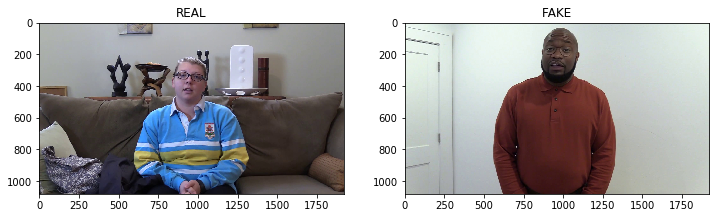

In [8]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].imshow(im_real)
ax[0].set_title('REAL')

ax[1].imshow(im_fake)
ax[1].set_title('FAKE');

## Extract faces

In [9]:
im_real_faces = face_extractor.process_image(img=im_real)
im_fake_faces = face_extractor.process_image(img=im_fake)

In [10]:
im_real_face = im_real_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
im_fake_face = im_fake_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace

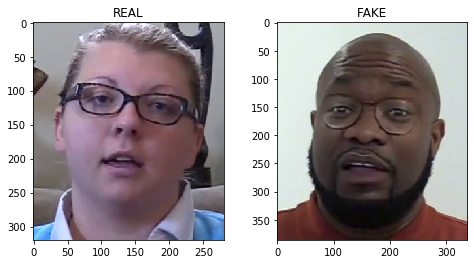

In [11]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

## Predict scores

In [12]:
faces_t = torch.stack( [ transf(image=im)['image'] for im in [im_real_face,im_fake_face] ] )

with torch.no_grad():
    faces_pred = torch.sigmoid(net(faces_t.to(device))).cpu().numpy().flatten()

In [13]:
"""
Print scores.
A score close to 0 predicts REAL. A score close to 1 predicts FAKE.
"""
print('Score for REAL face: {:.4f}'.format(faces_pred[0]))
print('Score for FAKE face: {:.4f}'.format(faces_pred[1]))

Score for REAL face: 0.0079
Score for FAKE face: 0.9941
